In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import gc #garbage collector
import sys
import os
from pandas.api.types import CategoricalDtype
#from xgboost import XGBRegressor as xgb
import xgboost as xgb
from itertools import product
from statistics import stdev 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from datetime import date
import pickle
import pyodbc
import time
from tqdm import tqdm
import copy
from pathlib import Path
import datetime
from datetime import date
from xgboost import XGBRegressor
from dateutil.relativedelta import *
from pandas import ExcelWriter
from sklearn2pmml import sklearn2pmml
from sklearn_pandas import DataFrameMapper
from sklearn2pmml import PMMLPipeline
from sklearn2pmml import Pipeline
from sklearn.preprocessing import LabelBinarizer
from sklearn2pmml.decoration import CategoricalDomain, ContinuousDomain
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn2pmml.preprocessing.xgboost import make_xgboost_column_transformer
from sklearn.pipeline import Pipeline
from sklearn2pmml.preprocessing import PMMLLabelEncoder
from sklearn2pmml import make_pmml_pipeline
from sklearn.preprocessing import LabelEncoder


In [2]:
def merge_genes(file_list, output_file):
    # Create an empty dataframe
    df = pd.DataFrame()

    # Use a for loop to iterate over the Excel files
    for file in file_list:
        # Read each Excel file into a separate dataframe
        data = pd.read_csv(file)

        # Append the data from each dataframe to the empty dataframe
        df = df.append(data)

    # Save the merged data to a new Excel file
    df.to_csv(output_file, index=False)

# Example usage
file_list = ['gnomAD_ABCA4.csv', 'gnomAD_APC.csv', 'gnomAD_ATM.csv', 'gnomAD_BRCA1.csv', 'gnomAD_BRCA2.csv',
              'gnomAD_DOCK7.csv', 'gnomAD_FBN1.csv' , 'gnomAD_MSH2.csv' , 'gnomAD_MSH6.csv' , 'gnomAD_NF1.csv',
              'gnomAD_TSC2.csv' , 'gnomAD_TTN.csv']
merge_genes(file_list, 'Genes_Merge_Data.csv')


In [3]:
df_merge_data = pd.read_csv(r"C:\Users\ENES\Desktop\eResult\VUSGEN_22.11.2022\1.Data\Genes_Merge_Data.csv")

In [4]:
mask = df_merge_data['ClinVar Clinical Significance'].isna()
# Count the number of missing values in each column
na_count = mask.sum()
na_count

44172

In [5]:
#Drop unnecessary columns
df_merge_data = df_merge_data.drop(['Homozygote Count Latino/Admixed American', 'Hemizygote Count Latino/Admixed American',
                                   'Allele Count Ashkenazi Jewish','Allele Number Ashkenazi Jewish',
                                   'Homozygote Count Ashkenazi Jewish', 'Hemizygote Count Ashkenazi Jewish',
                                   'Allele Count East Asian', 'Allele Number East Asian','Homozygote Count East Asian',
                                   'Hemizygote Count East Asian','Allele Count European (Finnish)',
                                   'Allele Number European (Finnish)','Homozygote Count European (Finnish)',
                                   'Hemizygote Count European (Finnish)','Allele Count European (non-Finnish)',
                                   'Allele Number European (non-Finnish)','Homozygote Count European (non-Finnish)',
                                   'Hemizygote Count European (non-Finnish)','Allele Count Other','Allele Number Other',
                                   'Homozygote Count Other','Hemizygote Count Other','Allele Count South Asian',
                                   'Allele Number South Asian','Homozygote Count South Asian','Hemizygote Count South Asian',
                                    'Source', 'Filters - exomes', 'Filters - genomes',
                                    'Transcript' , 'ClinVar Variation ID', 'Flags' , 'Allele Number', 
                                    'Allele Count African/African American',
                                    'Allele Number African/African American', 'Homozygote Count African/African American',
                                    'Allele Number African/African American', 'Homozygote Count African/African American',
                                    'Hemizygote Count African/African American','Allele Count Latino/Admixed American',
                                    'Allele Number Latino/Admixed American'], axis=1)

In [6]:
df_merge_data = df_merge_data.dropna(subset=['ClinVar Clinical Significance'])

In [7]:
df_merge_data['ClinVar Clinical Significance'].value_counts()

Uncertain significance                                                    11526
Likely benign                                                              8885
Conflicting interpretations of pathogenicity                               5446
Benign/Likely benign                                                       1751
Benign                                                                     1171
Pathogenic                                                                  704
Pathogenic/Likely pathogenic                                                290
Likely pathogenic                                                           213
not provided                                                                137
Pathogenic/Likely pathogenic; other                                           1
Pathogenic; other                                                             1
Conflicting interpretations of pathogenicity; association; risk factor        1
Name: ClinVar Clinical Significance, dty

In [8]:
labelencoder = LabelEncoder()
df_merge_data['Reference_L'] = labelencoder.fit_transform(df_merge_data['Reference'])
df_merge_data['Alternate_L'] = labelencoder.fit_transform(df_merge_data['Alternate'])
df_merge_data['HGVS Consequence_L'] = labelencoder.fit_transform(df_merge_data['HGVS Consequence'])
df_merge_data['Protein Consequence_L'] = labelencoder.fit_transform(df_merge_data['Protein Consequence'])
df_merge_data['Transcript Consequence_L'] = labelencoder.fit_transform(df_merge_data['Transcript Consequence'])
df_merge_data['VEP Annotation_L'] = labelencoder.fit_transform(df_merge_data['VEP Annotation'])

In [9]:
df_merge_data = df_merge_data.drop(['Reference', 'Alternate', 'HGVS Consequence', 'Protein Consequence',
                                   'Transcript Consequence', 'VEP Annotation'], axis=1)

In [10]:
#df_merge_data.to_excel('VUS_Final_Data.xlsx')

In [11]:
df_merge_data["ClinVar Clinical Significance"].value_counts()

Uncertain significance                                                    11526
Likely benign                                                              8885
Conflicting interpretations of pathogenicity                               5446
Benign/Likely benign                                                       1751
Benign                                                                     1171
Pathogenic                                                                  704
Pathogenic/Likely pathogenic                                                290
Likely pathogenic                                                           213
not provided                                                                137
Pathogenic/Likely pathogenic; other                                           1
Pathogenic; other                                                             1
Conflicting interpretations of pathogenicity; association; risk factor        1
Name: ClinVar Clinical Significance, dty

In [12]:
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Uncertain significance", "1")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Likely benign", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Conflicting interpretations of pathogenicity", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Benign/Likely benign", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Benign", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Pathogenic", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Pathogenic/Likely pathogenic", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("not provided", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Pathogenic/Likely pathogenic; other", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Pathogenic; other", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Conflicting interpretations of pathogenicity; association; risk factor", "0")
df_merge_data["ClinVar Clinical Significance"] = df_merge_data["ClinVar Clinical Significance"].replace("Likely pathogenic", "0")

In [14]:
df_merge_data.dtypes

Chromosome                         int64
Position                           int64
rsIDs                             object
ClinVar Clinical Significance     object
Allele Count                       int64
Allele Frequency                 float64
Homozygote Count                   int64
Hemizygote Count                   int64
Reference_L                        int32
Alternate_L                        int32
HGVS Consequence_L                 int32
Protein Consequence_L              int32
Transcript Consequence_L           int32
VEP Annotation_L                   int32
dtype: object

In [16]:
df_merge_data['ClinVar Clinical Significance'] = df_merge_data['ClinVar Clinical Significance'].astype('int64')

In [18]:
df_merge_data["ClinVar Clinical Significance"].value_counts()

0    18600
1    11526
Name: ClinVar Clinical Significance, dtype: int64

In [22]:
df_merge_data.rename(columns={"ClinVar Clinical Significance": "TARGET"}, inplace=True)

## Modelling Part(XGBoost)

In [24]:
df_merge_data = df_merge_data.drop(['Position', 'rsIDs'], axis=1)

In [26]:
X = df_merge_data.drop('TARGET', axis=1)

y = df_merge_data['TARGET']

In [29]:
from sklearn.model_selection import train_test_split

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# define the model
xgb_model = xgb.XGBClassifier()

# define the hyperparameters to tune
params = {
    "max_depth": [5],
    "learning_rate": [0.1],
    "n_estimators": [500]
}

# use grid search to tune the hyperparameters
clf = GridSearchCV(xgb_model, params, cv=5)
clf.fit(X_train, y_train)

# print the best hyperparameters found by grid search
print(clf.best_params_)

# use the best hyperparameters to train the model
xgb_model = xgb.XGBClassifier(**clf.best_params_)
xgb_model.fit(X_train, y_train)

# evaluate the model on the test set
predictions = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
Accuracy: 88.02%


In [35]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, predictions, average='binary')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.8312236286919831
Recall: 0.8595113438045375
F1 Score: 0.845130845130845


In [58]:
from sklearn.metrics import roc_auc_score, plot_roc_curve
#area under curve score
auc = roc_auc_score(y_test, predictions)
auc

0.8761938079494033

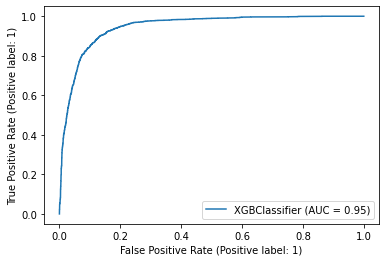

In [40]:
#ROC Curve
plot_roc_curve(xgb_model, X_test, y_test)

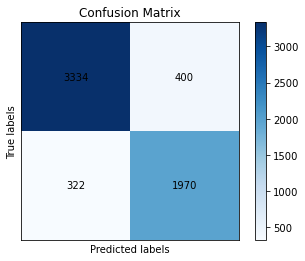

In [77]:
from sklearn.metrics import confusion_matrix

# make predictions on the test dataset
y_pred = xgb_model.predict(X_test)

# generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

df = pd.DataFrame(cm, index=['True Negative', 'True Positive'], columns=['Predicted Negative', 'Predicted Positive'])

plt.imshow(cm, cmap=plt.cm.Blues)

# add the numbers from the confusion matrix to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


In [74]:
df

,Predicted Negative,Predicted Positive
True Negative,3334,400
True Positive,322,1970


In [56]:
Gini = 2*(auc) - 1
Gini

0.7523876158988065

In [57]:
import numpy as np
from scipy.stats import entropy

def population_stability_index(y_test, predictions):
    # calculate the true and predicted population distributions
    true_dist = np.bincount(y_test) / len(y_test)
    pred_dist = np.bincount(predictions) / len(predictions)

    # calculate the entropy of the true distribution
    true_entropy = entropy(true_dist)

    # calculate the PSI score
    psi = np.abs(true_dist - pred_dist).sum() / true_entropy

    return psi

population_stability_index(y_test, predictions)

0.0389738223917121

In [66]:
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows

importances = xgb_model.get_booster().get_score(importance_type='weight')
df = pd.DataFrame.from_dict(importances, orient='index', columns=['Importance'])
wb = Workbook()
ws = wb.active
for r in dataframe_to_rows(df, index=True, header=True):
    ws.append(r)
wb.save('feature_importances.xlsx')